###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

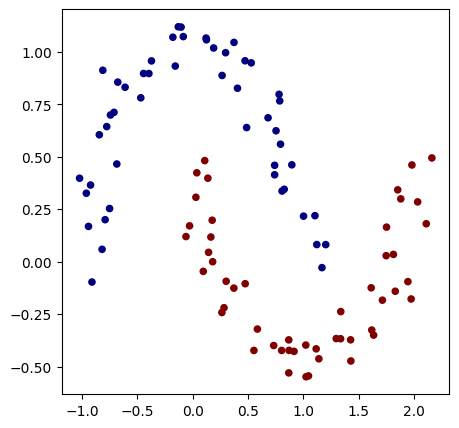

In [3]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
def unfrozen_info(model):
    fls = [(lid, l) for lid, l in enumerate(model.layers) if not l.frozen]
    if len(fls) == 0:
        return
    params = [(id, n) for id, n in enumerate(fls[0][1].parameters())]
    params = [(fls[0][0], id, p.grad, p.learning_rate, p.learning_rate * p.grad) for id, p in params if p.learning_rate > 0.0]
    params.sort(key=lambda p: p[1])
    return params

In [5]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(2, [8, 32, 8, 1], act='tanh') # 1-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2), tanh-Neuron(2)], Layer of [tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8), tanh-Neuron(8)], Layer of [tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32), tanh-Neuron(32)], Layer of [linear-Neuron(8)]]
number of parameters 585


In [6]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
#total_loss.backward()
#model.init_lr()

print(total_loss, acc, len(model.parameters()))

Value(data=2.5973877096400817, pgrad=0.0, grad=0.0, lr=1.0) 0.22 585


In [7]:
# optimization
for k in range(1000):

    # forward
    total_loss, acc = loss()
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.learn(0.5)

    # if model.freeze():
    #    print('Early Stop by FREEZE!')
    #    break

total_loss, acc = loss()
model.zero_grad()
total_loss.backward()
print(f"final loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 2.5973877096400817, accuracy 22.0%
step 1 loss 0.5994416765665169, accuracy 84.0%
step 2 loss 0.6700414896410218, accuracy 79.0%
step 3 loss 0.672998232678796, accuracy 85.0%
step 4 loss 0.3915363874282799, accuracy 83.0%
step 5 loss 0.3914451243173976, accuracy 86.0%
step 6 loss 0.3228240173554647, accuracy 87.0%
step 7 loss 0.30073474348665286, accuracy 90.0%
step 8 loss 0.2803030448229938, accuracy 88.0%
step 9 loss 0.26010383719808494, accuracy 90.0%
step 10 loss 0.23994289632737734, accuracy 91.0%
step 11 loss 0.21820125725952796, accuracy 91.0%
step 12 loss 0.19535153435357236, accuracy 92.0%
step 13 loss 0.1735666782757915, accuracy 93.0%
step 14 loss 0.15627290708519703, accuracy 95.0%
step 15 loss 0.14406051234666953, accuracy 97.0%
step 16 loss 0.13315990135721312, accuracy 97.0%
step 17 loss 0.12596797015366346, accuracy 97.0%
step 18 loss 0.11883407350836567, accuracy 97.0%
step 19 loss 0.11178455196994003, accuracy 97.0%
step 20 loss 0.10488417597312669, accura

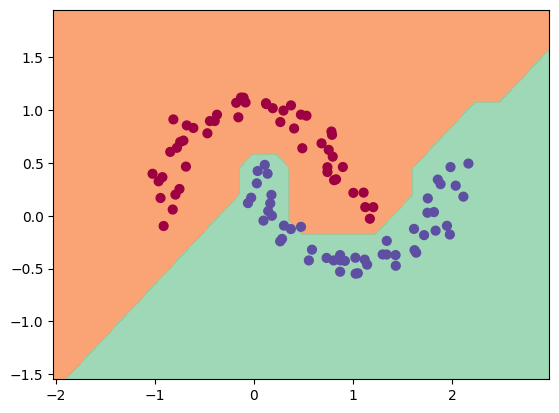

In [9]:
# visualize decision boundary
def visual():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visual()

In [10]:
model.parameters()

[Value(data=-1.6942272070117872, pgrad=-0.004687092096198981, grad=-0.004687178524309223, lr=2.4072805389957887e-05),
 Value(data=0.7217772417958729, pgrad=0.0013012495018395885, grad=0.0013012564265419357, lr=5.57030517985059e-05),
 Value(data=0.01667606818008106, pgrad=-0.010938736450260673, grad=-0.010938857743827333, lr=2.80838877101661e-09),
 Value(data=2.5225420818801005, pgrad=0.015270185907555016, grad=0.015270251347654492, lr=1.2273515782496021e-05),
 Value(data=-1.2429187995367286, pgrad=-0.003778736367717283, grad=-0.0037787503233888096, lr=0.0047025761970643214),
 Value(data=-0.5312330800866034, pgrad=0.03298651670034551, grad=0.03298667125819089, lr=3.6914105906048134e-08),
 Value(data=-0.7067594221408497, pgrad=0.004316480303802001, grad=0.004316582292454363, lr=1.9932603661985692e-08),
 Value(data=0.41060608370607904, pgrad=-6.23799243137978e-05, grad=-6.237090848846928e-05, lr=1.3000755449113173e-07),
 Value(data=-0.64071119140176, pgrad=0.009028312080359525, grad=0.009

# tanh

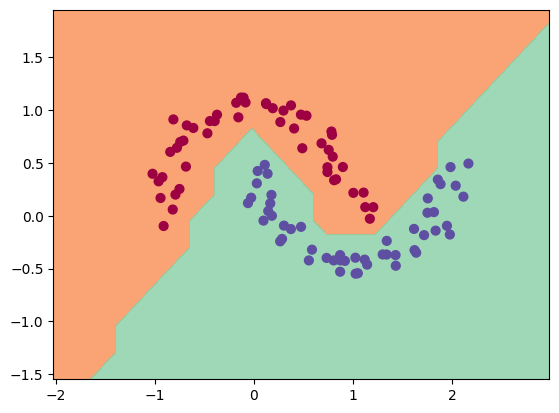

In [8]:
visual()

# relu

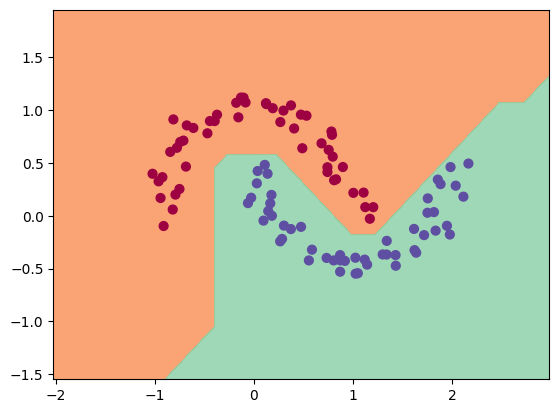

In [12]:
visual()

# tanh with dynamic learning rate <0.5, 1.1>

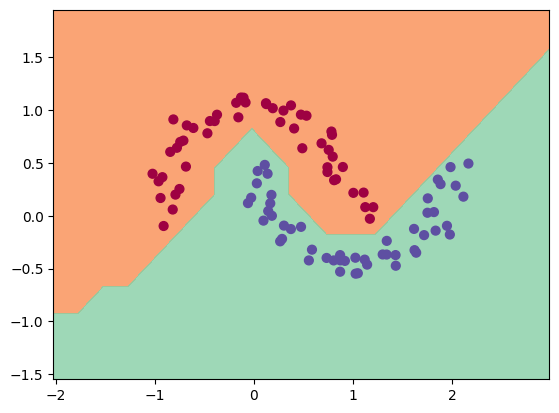

In [8]:
visual()

# relu with dynamic learning rate <0.5, 1.1>

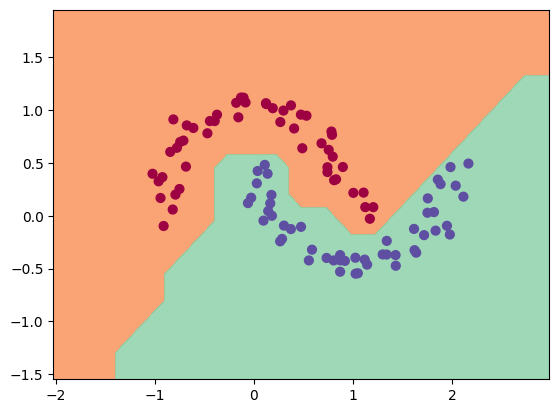

In [22]:
visual()